In [ ]:
import pandas as pd

# Load the IMDB dataset
# Replace 'path_to_your_file' with the actual path to your IMDB dataset
imdb_data = pd.read_csv('/content/IMDb_Data_final.csv')

# Combine fields to create a descriptive text for each movie
imdb_data['Combined_Text'] = imdb_data.apply(
    lambda row: f"{row['Title']} directed by {row['Director']} starring {row['Stars']} in the {row['Category']} genre.",
    axis=1
)

# Display the first few combined texts to verify
print("Sample Combined Text:\n", imdb_data['Combined_Text'].head())


Sample Combined Text:
 0    Top Gun: Maverick directed by JosephKosinski s...
1    Everything Everywhere All at Once directed by ...
2    The Batman directed by MattReeves starring Rob...
3    Jurassic Park directed by StevenSpielberg star...
4    The Godfather directed by FrancisFordCoppola s...
Name: Combined_Text, dtype: object


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for Combined_Text
imdb_data['Embedding'] = imdb_data['Combined_Text'].apply(lambda x: model.encode(x))
embeddings = np.vstack(imdb_data['Embedding'].values)  # Stack embeddings into a 2D array

# Display the shape and a few sample embeddings
print("Shape of Embeddings:", embeddings.shape)
print("Sample Embeddings:\n", embeddings[:2])


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of Embeddings: (1000, 384)
Sample Embeddings:
 [[-7.85223618e-02 -1.47853158e-02 -5.66053726e-02 -2.06327830e-02
   2.28275508e-02  4.90228869e-02  2.10219584e-02  6.12590052e-02
  -2.45449003e-02  3.59693961e-03 -4.81441058e-02  2.88872309e-02
   7.47076496e-02  5.52988052e-02 -9.84501443e-04  2.46691313e-02
   8.63037631e-02  9.12472531e-02  7.26895854e-02  8.15211423e-03
  -7.27289096e-02  1.46160112e-03  1.58165582e-02  3.86519656e-02
  -3.04145087e-02 -1.93068702e-02  5.46048023e-02  8.07028711e-02
  -1.74342826e-01 -3.61542553e-02  4.51822616e-02  1.53239788e-02
  -1.05806574e-01  1.99611951e-02  3.54970656e-02 -8.24165344e-03
  -4.91811102e-03 -8.59470945e-03 -2.80631948e-02 -5.10950573e-04
  -1.36827482e-02  8.57705716e-03  1.72092970e-02  1.47377364e-02
   5.61422110e-03 -7.08398074e-02 -4.73787822e-02 -5.86002059e-02
   2.11286768e-02  2.51344573e-02 -1.27420396e-01 -7.73349702e-02
  -5.48362434e-02 -4.54258583e-02  8.36705342e-02 -4.69069444e-02
   2.77147125e-02 -2.28

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 44.8 MB/s eta 0:00:00


In [ ]:
import faiss

# FAISS IVF Setup
embedding_dim = embeddings.shape[1]
nlist = 100  # Number of clusters
quantizer = faiss.IndexFlatL2(embedding_dim)
faiss_ivf_index = faiss.IndexIVFFlat(quantizer, embedding_dim, nlist)

# Train and add embeddings to the FAISS index
faiss_ivf_index.train(embeddings)
faiss_ivf_index.add(embeddings)
print("FAISS IVF Index built with", embeddings.shape[0], "embeddings.")


FAISS IVF Index built with 1000 embeddings.


In [ ]:
!pip install annoy
from annoy import AnnoyIndex

# Annoy Setup
annoy_index = AnnoyIndex(embedding_dim, 'angular')
for i, vec in enumerate(embeddings):
    annoy_index.add_item(i, vec)
annoy_index.build(10)  # Using 10 trees for efficient search
print("Annoy Index built with", embeddings.shape[0], "embeddings.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552445 sha256=27260f1f6f6d92a88b3473b4b08516c338ba0f7648b371d44585ed4c9bb638c0
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy
Annoy Index built with 1000 embeddings.


In [ ]:
# HNSW Setup (Hierarchical Navigable Small World)
hnsw_index = faiss.IndexHNSWFlat(embedding_dim, 32)  # HNSW with 32 links
hnsw_index.add(embeddings)
print("HNSW Index built with", embeddings.shape[0], "embeddings.")


HNSW Index built with 1000 embeddings.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF for Text + Vector Search
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(imdb_data['Combined_Text'])
print("TF-IDF Matrix built with shape:", tfidf_matrix.shape)


TF-IDF Matrix built with shape: (1000, 5033)


In [ ]:
from scipy.spatial import distance

# Define various distance metrics
distance_metrics = {
    "cosine": distance.cosine,
    "euclidean": distance.euclidean,
    "manhattan": distance.cityblock,
    "chebyshev": distance.chebyshev,
    "canberra": distance.canberra,
    "braycurtis": distance.braycurtis,
    "correlation": distance.correlation,
    "jaccard": lambda x, y: distance.jaccard((x > 0).astype(int), (y > 0).astype(int)),
    "mahalanobis": lambda x, y: distance.mahalanobis(x, y, np.cov(embeddings.T))
}

# Function to calculate similarity scores across all metrics for a given query and neighbor set
def calculate_similarity(query_embedding, neighbor_embeddings):
    results = {}
    for metric_name, metric_func in distance_metrics.items():
        similarities = [metric_func(query_embedding, neighbor) for neighbor in neighbor_embeddings]
        normalized_similarities = [2 * s - 1 for s in similarities]  # Normalize to -1 to +1
        results[metric_name] = normalized_similarities
    return results



In [ ]:
def calculate_standard_deviation(similarity_scores):
    # Calculate the standard deviation for each set of similarity scores
    std_devs = {metric: np.std(scores) for metric, scores in similarity_scores.items()}
    return std_devs


In [ ]:
# Define query and number of neighbors
query = "A science fiction movie with action and adventure"
query_embedding = model.encode(query)
k = 10  # Number of neighbors to retrieve

# Store results in a dictionary
ann_results = {}

# FAISS IVF
_, faiss_ivf_neighbors = faiss_ivf_index.search(np.array([query_embedding]), k)
ann_results["FAISS_IVF"] = faiss_ivf_neighbors[0]

# Annoy
annoy_neighbors = annoy_index.get_nns_by_vector(query_embedding, k)
ann_results["Annoy"] = annoy_neighbors

# HNSW
_, hnsw_neighbors = hnsw_index.search(np.array([query_embedding]), k)
ann_results["HNSW"] = hnsw_neighbors[0]

# TF-IDF
tfidf_query_vec = tfidf_vectorizer.transform([query])
tfidf_scores = cosine_similarity(tfidf_query_vec, tfidf_matrix).flatten()
tfidf_neighbors = np.argsort(tfidf_scores)[-k:][::-1]
ann_results["TF-IDF"] = tfidf_neighbors

# Print results for verification
print("ANN Results:", ann_results)



ANN Results: {'FAISS_IVF': array([  3, 131, 237,  61,  -1,  -1,  -1,  -1,  -1,  -1]), 'Annoy': [121, 3, 523, 235, 131, 668, 26, 361, 393, 853], 'HNSW': array([121,   3, 523, 235, 132, 131, 229, 375, 668, 335]), 'TF-IDF': array([386,  37, 517, 302, 246, 315, 652, 678, 312, 888])}


In [ ]:
# Initialize variables to find the best pair
best_algo_metric_pair = None
lowest_std_dev = float('inf')

# Print the standard deviation for each algorithm-metric pair
print("Standard Deviations for Each Algorithm-Metric Pair:")
for algo, metrics in average_std_dev.items():
    print(f"\nAlgorithm: {algo}")
    for metric, std_dev in metrics.items():
        print(f"  Distance Metric: {metric}, Standard Deviation: {std_dev:.4f}")
        # Find the best pair (lowest standard deviation)
        if std_dev < lowest_std_dev:
            lowest_std_dev = std_dev
            best_algo_metric_pair = (algo, metric)

# Print the best algorithm-metric pair
print("\nBest Algorithm-Metric Pair:")
print(f"Algorithm: {best_algo_metric_pair[0]}, Distance Metric: {best_algo_metric_pair[1]}")
print(f"Lowest Standard Deviation: {lowest_std_dev:.4f}")



Standard Deviations for Each Algorithm-Metric Pair:

Algorithm: FAISS_IVF
  Distance Metric: cosine, Standard Deviation: 0.2690
  Distance Metric: euclidean, Standard Deviation: 0.2421
  Distance Metric: manhattan, Standard Deviation: 4.1603
  Distance Metric: chebyshev, Standard Deviation: 0.0184
  Distance Metric: canberra, Standard Deviation: 36.6157
  Distance Metric: braycurtis, Standard Deviation: 0.2346
  Distance Metric: correlation, Standard Deviation: 0.2690
  Distance Metric: jaccard, Standard Deviation: 0.1075
  Distance Metric: mahalanobis, Standard Deviation: 0.0503

Algorithm: Annoy
  Distance Metric: cosine, Standard Deviation: 0.0398
  Distance Metric: euclidean, Standard Deviation: 0.0409
  Distance Metric: manhattan, Standard Deviation: 0.6859
  Distance Metric: chebyshev, Standard Deviation: 0.0192
  Distance Metric: canberra, Standard Deviation: 8.3708
  Distance Metric: braycurtis, Standard Deviation: 0.0343
  Distance Metric: correlation, Standard Deviation: 0.03

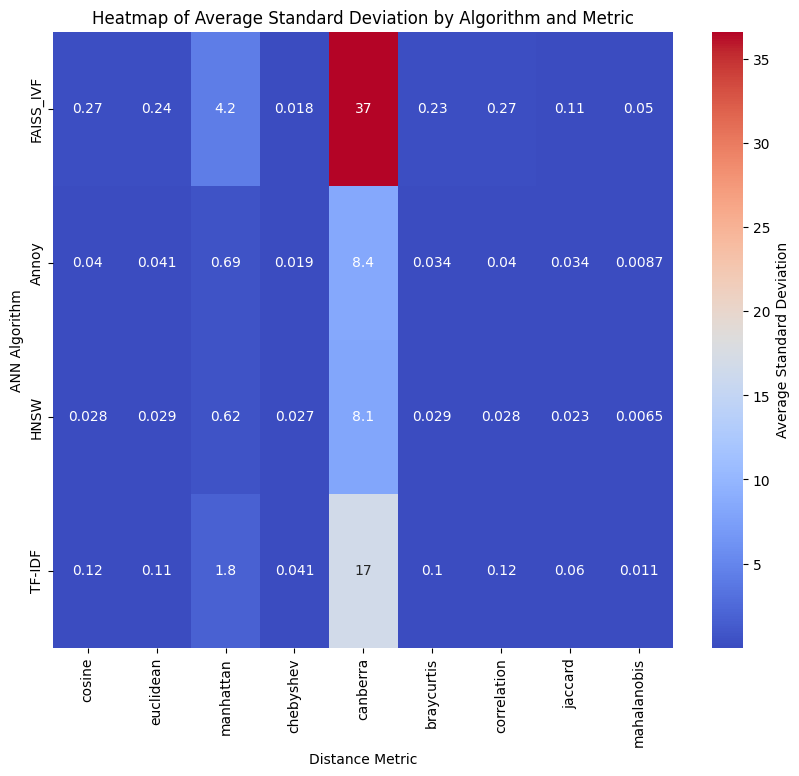

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average standard deviation for each algorithm-metric pair
average_std_dev = {
    algo: {
        metric: np.mean(
            [
                calculate_standard_deviation(
                    calculate_similarity(query_embedding, [embeddings[idx] for idx in ann_results[algo]])
                )[metric]
            ]
        )
        for metric in distance_metrics.keys()
    }
    for algo in ann_results.keys()
}

# Visualize as a heatmap
heatmap_data = pd.DataFrame(average_std_dev).T
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, cmap="coolwarm", cbar_kws={"label": "Average Standard Deviation"}
)
plt.title("Heatmap of Average Standard Deviation by Algorithm and Metric")
plt.xlabel("Distance Metric")
plt.ylabel("ANN Algorithm")
plt.show()


In [ ]:
# Print the average standard deviation for each algorithm
print("\nAverage Standard Deviation for Each Algorithm:")
for algo, avg_std in avg_std_dev_per_algo.items():
    print(f"Algorithm: {algo}, Average Standard Deviation: {avg_std:.4f}")



Average Standard Deviation for Each Algorithm:
Algorithm: FAISS_IVF, Average Standard Deviation: 4.6630
Algorithm: Annoy, Average Standard Deviation: 1.0304
Algorithm: HNSW, Average Standard Deviation: 0.9906
Algorithm: TF-IDF, Average Standard Deviation: 2.1109


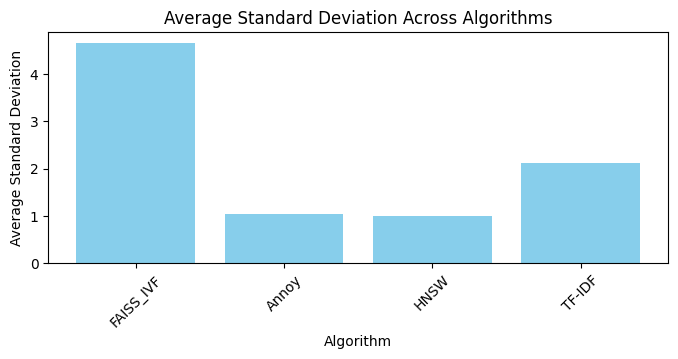

In [ ]:
import matplotlib.pyplot as plt

# Data for visualization
algorithms = list(avg_std_dev_per_algo.keys())
avg_std_values = list(avg_std_dev_per_algo.values())

# Create bar plot
plt.figure(figsize=(8, 3))
plt.bar(algorithms, avg_std_values, color='skyblue')
plt.title("Average Standard Deviation Across Algorithms")
plt.xlabel("Algorithm")
plt.ylabel("Average Standard Deviation")
plt.xticks(rotation=45)
plt.show()


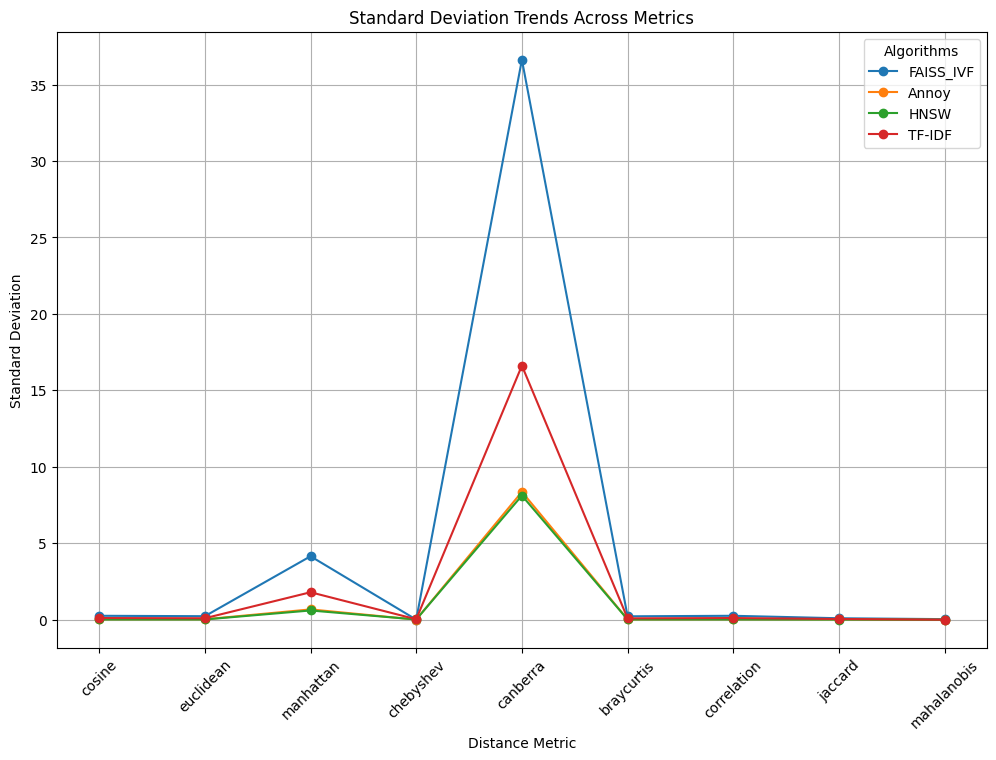

In [ ]:
# Data preparation for line plot
metrics = list(distance_metrics.keys())

plt.figure(figsize=(12, 8))

# Plot for each algorithm
for algo, metric_values in average_std_dev.items():
    plt.plot(metrics, list(metric_values.values()), label=algo, marker='o')

plt.title("Standard Deviation Trends Across Metrics")
plt.xlabel("Distance Metric")
plt.ylabel("Standard Deviation")
plt.xticks(rotation=45)
plt.legend(title="Algorithms")
plt.grid(True)
plt.show()
